<table>
  <tr>
      <td><div align="left"><font size="20" >Finding Aruco markers</font></div></td>
     <td><img src="images/RVSS-logo.png" width="400"></td>
  </tr>
</table>

In [1]:
%matplotlib notebook

import sys
!{sys.executable} -m pip install machinevision-toolbox-python # used to install machinevision-toolbox into the kernel
!{sys.executable} -m pip install opencv-contrib-python==4.4.0.46 # update opencv to 4.4.0

import numpy as np
import math
from spatialmath import SE3, SO3
from spatialmath.base import e2h, h2e
from machinevisiontoolbox import Image, plot_point
import cv2

  Using cached machinevision_toolbox_python-0.5.4-py3-none-any.whl
  Using cached ansitable-0.9.5-py3-none-any.whl
  Using cached colored-1.4.2-py3-none-any.whl
     |████████████████████████████████| 50.4 MB 48 kB/s s eta 0:00:01
  Using cached spatialmath_python-0.8.8-py3-none-any.whl
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/chainer_p36/bin/python -m pip install --upgrade pip' command.
  Using cached opencv_contrib_python-4.4.0.46-cp36-cp36m-manylinux2014_x86_64.whl (55.7 MB)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/chainer_p36/bin/python -m pip install --upgrade pip' command.


Aruco markers were developed as a simple way to mark things for augmented reality (AR) applications, hence the AR in their name.  They are just high-contrast grids that encode a number as well as position and orientation.

We will load a synthetic image of some Aruco markers, two with distortions, onto a picture from western Queensland.

<IPython.core.display.Javascript object>


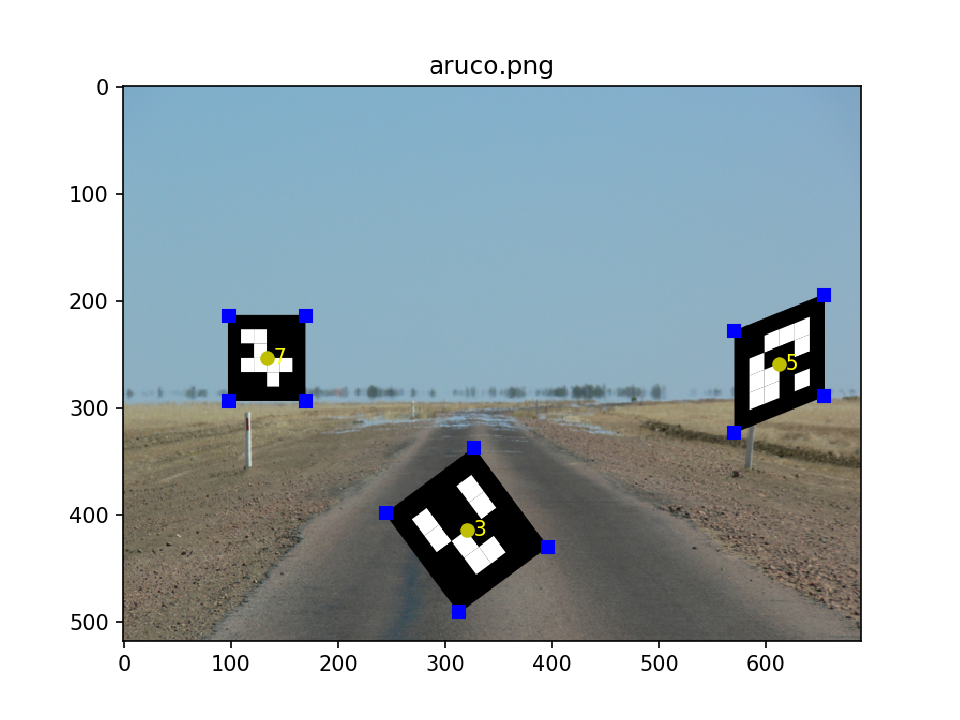

In [2]:
scene = Image('images/aruco.png')
scene.disp();

Before we can use OpenCV's Aruco module we need to define a dictionary that describes the Aruco marker pattern.  There are many different Aruco marker families, here we are using `4x4_1000` which is a $4 \times 4$ grid of squares that can encode numbers from 0 to 9999.

In [3]:
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)

We pass the dictionary and the image to the marker detector function

In [4]:
markers, ids, _ = cv2.aruco.detectMarkers(scene.image, dictionary)

`ids` is an array containing the identities of the three markers found in this image

In [5]:
ids

array([[3],
       [7],
       [5]], dtype=int32)

`markers` contains a list of $4\times 2$ arrays with the estimated corner locations for each marker

In [6]:
markers

[array([[[245., 398.],
         [327., 337.],
         [396., 430.],
         [313., 491.]]], dtype=float32),
 array([[[ 98., 214.],
         [170., 214.],
         [170., 293.],
         [ 98., 293.]]], dtype=float32),
 array([[[570., 228.],
         [654., 194.],
         [654., 289.],
         [570., 323.]]], dtype=float32)]

We can iterate over the markers and overlay the markers and Aruco id on the original image

In [7]:
for id, corners in zip(ids, markers):
    plot_point(corners.T, 'bs')
    centre = np.mean(corners, axis=1)
    plot_point(tuple(centre.flatten()), 'yo', text=f"{id[0]}", color='yellow')


For each marker we have the coordinates of four corners which is enough to estimate the orientation of the planar marker in 3D space.  In order to do this we need to know some parameters of the imaging setup

In [8]:
f = 500  # focal length of the camera in units of pixels (wild guess)
side = 1  # the side length of the marker in units of metres

From this we can estimate the camera's intrinsic parameter (lesson A2) matrix K

In [9]:
K = np.array([[f, 0, 344], [0, f, 260], [0, 0, 1]])
K

array([[500,   0, 344],
       [  0, 500, 260],
       [  0,   0,   1]])

and then estimate the position and orientation of each marker

In [10]:
rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(markers, side, K, None)

`rvecs` is the orientation of each marker expressed as an Euler vector

In [11]:
rvecs

array([[[ 2.90588439e+00, -1.02113760e+00, -4.13565083e-01]],

       [[ 3.13399645e+00,  2.97448235e-03, -2.65365850e-01]],

       [[ 3.43248170e+00, -4.92343335e-01,  5.31932676e-01]]])

We can convert the Euler vector to roll-pitch-yaw angles in units of degrees

In [12]:
for rvec in rvecs:
    R = SO3.EulerVec(rvec.flatten())
    print(R.rpy(unit='deg'))

[172.95736269  13.74897058 -39.57342126]
[-1.79781078e+02  9.67951760e+00  1.27295462e-01]
[-156.21639513  -13.68307689  -19.2198561 ]


`tvecs` is the 3D position of the centre of the marker with respect to the camera

In [13]:
tvecs

array([[[-2.24985219e-01,  1.37015679e+00,  4.44247832e+00]],

       [[-2.67010112e+00, -8.23096701e-02,  6.34291623e+00]],

       [[ 2.54155432e+00,  4.71298516e-04,  4.72302217e+00]]])